### `Load Libraries`

In [679]:
# Exploring and preprocessing
import re
import copy
import time
import warnings
import numpy as np
import pandas as pd
from textblob import Word
warnings.filterwarnings('ignore')

from textblob import TextBlob
from sklearn import preprocessing

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.base import TransformerMixin, BaseEstimator


# models 
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Visualization
import seaborn as sns
color = sns.color_palette("GnBu_d")
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# class imbalance handling
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
stop = set(stopwords.words('english'))


### `Loading data`

In [486]:
data = pd.read_csv("/Users/avaneeshkumar/Downloads/NLP_Case_Study/Data.csv", parse_dates=["tweet_created"])
tweet_data_copy = copy.deepcopy(data)

### `EDA on classes`

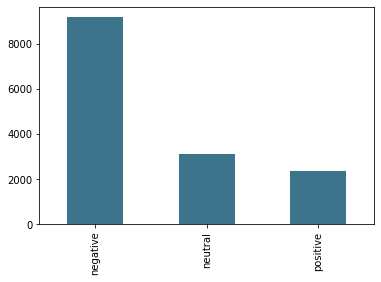

In [444]:
tweet_data["sentiment"].value_counts().plot("bar", color=color[1])

In [445]:
tweet_data["sentiment"].value_counts()[0]/sum(tweet_data["sentiment"].value_counts())

0.6269125683060109

* The classes are heavily imbalanced with negative values 62 percent data

* We can follow some sampling method to balance the imbalance but I am using F1 score with StratifiedKfold and stratified split to balance the imbalance during scoring. 

### `Data Cleaning & Preprocessing`

In [437]:
# Average Word Length
def avg_word(sentence):
        words = sentence.split()
        if len(words) == 0:
            pass
        else:
            return (sum(len(word) for word in words)/len(words))
    
    
# basic preprocessing steps
def text_processing(tweeet_data):

    # Number of Words
    tweeet_data['word_count'] = tweeet_data['text'].apply(lambda x: len(str(x).split(" ")))

    # Number of characters
    tweeet_data['char_count'] = tweeet_data['text'].str.len()
    
    # average word count for each word
    tweeet_data['avg_word'] = tweeet_data['text'].apply(lambda x: avg_word(x))

    # Number of stopwords
    tweeet_data['stopwords'] = tweeet_data['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
    
    # Number of mentions or hastags
    tweeet_data['hastags'] = tweeet_data['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
    
    # Number of numerics
    tweeet_data['numerics'] = tweeet_data['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
    
    # Number of uppercase words
    tweeet_data['upper'] = tweeet_data['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
    
    # Preprocessing test
    tweeet_data['text'] = tweeet_data['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    # Remove twitter handlers 
    tweeet_data['text'] = tweeet_data['text'].str.replace('@[^\s]+', " ")
    
    # removing special characters
    tweeet_data['text'] = tweeet_data['text'].str.replace("[^a-zA-Z#]", " ")
    
    # Removing Punctuation
    tweeet_data['text'] = tweeet_data['text'].str.replace('[^\w\s]',' ')
    
    # Removing stopwords
    tweeet_data['text'] = tweeet_data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    
    # Common word removal
    freq = pd.Series(' '.join(tweeet_data['text']).split()).value_counts()[:25]

    freq_ind = list(freq.index)
    tweeet_data['text'] = tweeet_data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_ind))

    # spelling correct removal
    # tweeet_data['text'].apply(lambda x: str(TextBlob(x).correct()))
    
    # small words
    tweeet_data['text'] = tweeet_data['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

    # Lemmatization
    tweeet_data['text'] = tweeet_data['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    
    # label encoding the output
    le = preprocessing.LabelEncoder()
    tweeet_data['label'] = le.fit_transform(tweeet_data.sentiment.values)
    
    return tweeet_data

### `Preprocessig`

In [487]:
tweet_data = text_processing(tweet_data_copy)

## count before preprocessing 
tweet_data['pre_clean_len'] =  [len(t) for t in data.text]

## count after preprocessing 
tweet_data['post_clean_len']=  [len(t) for t in tweet_data.text]

## `Some more EDA`

### `Pre-post count of words for processing`

Text(0.5, 0, 'Word count')

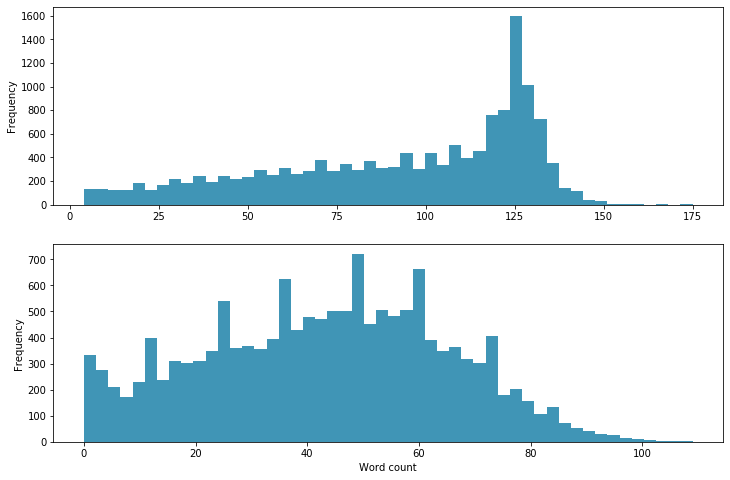

In [666]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8))

tweet_data["post_clean_len"].plot('hist', ax=axes[1], color=color[2], bins=50)
tweet_data["pre_clean_len"].plot("hist", ax=axes[0], color=color[2], bins=50)

plt.xlabel("Word count")

### `Box Plot to analyse the distrbution`

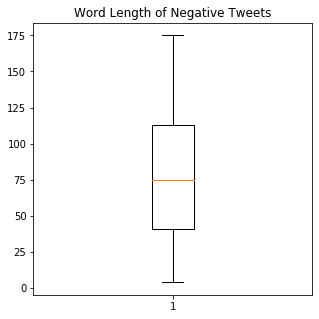

In [240]:
# Positive
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(tweet_data[tweet_data['label']== 1]["pre_clean_len"])
plt.title('Word Length of Negative Tweets')
plt.show()

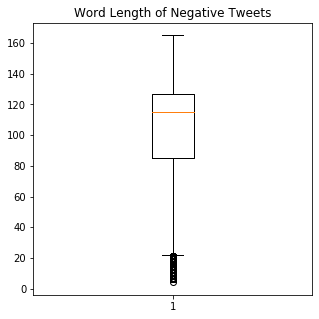

In [238]:
# positive
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(tweet_data[tweet_data['label']==0]["pre_clean_len"])
plt.title('Word Length of Negative Tweets')
plt.show()

* Few outliers in negative tweets and no outliers in positive tweet.

In [155]:
tweeet_data.head(3)

,tweet_id,sentiment,name,text,tweet_created,tweet_location,user_timezone,word_count,char_count,avg_word,stopwords,hastags,numerics,upper,label,pre_clean_len,post_clean_len
0,1,neutral,cairdin,said,2015-02-24 11:35:00,NaN,Eastern Time (US & Canada),1,4,4.000000,0,0,0,0,1,20,4
1,2,positive,jnardino,plus added commercial experience tacky,2015-02-24 11:15:00,NaN,Pacific Time (US & Canada),5,38,6.800000,0,0,0,0,2,57,38
2,3,neutral,yvonnalynn,must mean take another trip,2015-02-24 11:15:00,Lets Play,Central Time (US & Canada),6,33,4.666667,0,0,0,0,1,56,27


### `Word Cloud `

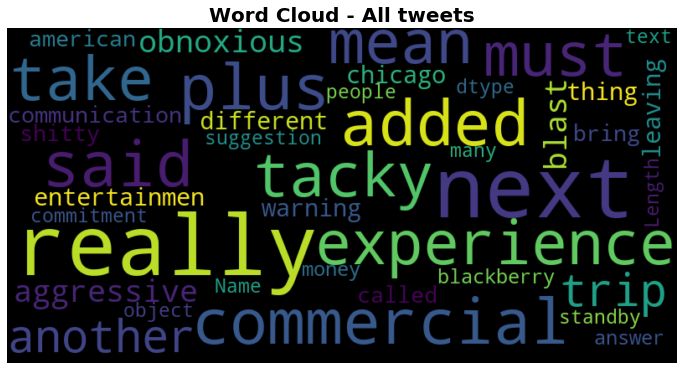

In [129]:
# For all words
wordcloud = WordCloud(width=800, height=400,max_font_size=100).generate(str(tweet_data['text']))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud - All tweets',fontsize=20,fontweight='bold')
plt.show()

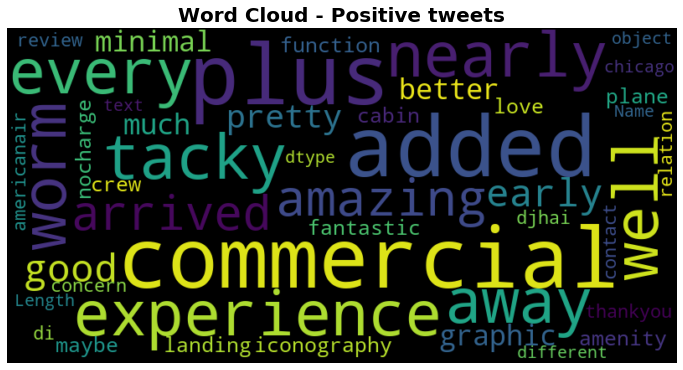

In [130]:
#Word cloud of positive tweets
wordcloud = WordCloud(width=800, height=400,max_font_size=100).generate(
    str(tweeet_data[tweeet_data['label']==2]['text']))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud - Positive tweets',fontsize=20,fontweight='bold')
plt.show()


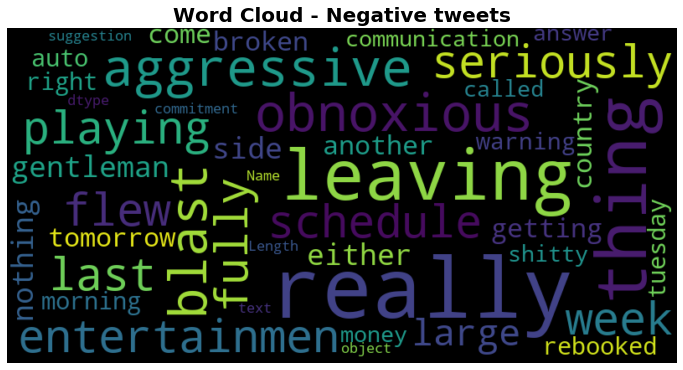

In [133]:
#Word cloud of negative tweets
wordcloud = WordCloud(width=800, height=400,max_font_size=100).generate(
    str(tweeet_data[tweeet_data['label']==0]['text']))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud - Negative tweets',fontsize=20,fontweight='bold')
plt.show()

Text(0.5, 0, 'Avg word count')

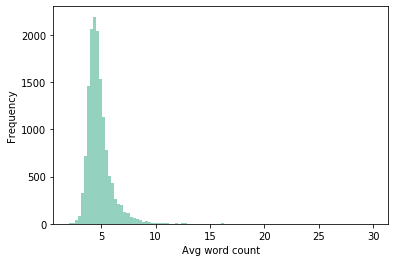

In [668]:
## avreage alphabet count in a word per tweet
tweet_data["avg_word"].plot("hist", color=color[5], bins=100)
plt.xlabel("Avg word count", fontsize=10)

### `Emoticons`

In [356]:
import re
tweets_text = data.text.str.cat()
emos = set(re.findall(r" ([xX:;][-']?.) ",tweets_text))
emos_count = []
for emo in emos:
    emos_count.append((tweets_text.count(emo), emo))
sorted(emos_count,reverse=True)

[(1228, ':/'),
 (354, ': '),
 (157, ':)'),
 (90, ':('),
 (43, ';)'),
 (28, ':-)'),
 (9, ';-)'),
 (9, ':-('),
 (8, 'XT'),
 (8, ':D'),
 (6, ':-/'),
 (4, 'XW'),
 (4, ':P'),
 (1, '::')]

In [357]:
HAPPY_EMO = r" ([xX;:]-?[dD)]|:-?[\)]|[;:][pP]) "
SAD_EMO = r" (:'?[/|\(]) "
print("Happy emoticons:", set(re.findall(HAPPY_EMO, tweets_text)))
print("Sad emoticons:", set(re.findall(SAD_EMO, tweets_text)))

Happy emoticons: {':)', ';)', ':P', ':D', ';-)', ':-)'}
Sad emoticons: {':(', ':/'}


### `Most common words`

In [358]:
import nltk
from nltk.tokenize import word_tokenize

# Uncomment this line if you haven't downloaded punkt before
# or just run it as it is and uncomment it if you got an error.
#nltk.download('punkt')
def most_used_words(text):
    tokens = word_tokenize(text)
    frequency_dist = nltk.FreqDist(tokens)
    print("There is %d different words" % len(set(tokens)))
    return sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)

In [359]:
from nltk.corpus import stopwords

#nltk.download("stopwords")

mw = most_used_words(tweet_data.text.str.cat())
most_words = []
for w in mw:
    if len(most_words) == 1000:
        break
    # though we have already removed the 
    if w in stopwords.words("english"):
        continue
    else:
        most_words.append(w)

There is 20637 different words


### `We have 3 most popular ways to create features:`
* Bag-of-Words
* TF-IDF
* Word Embeddings

And we wil only use the top 2 for ML model and Word Embedding for Deep Learning model

#### Bag of Words (BOW)
* We are going to use the Bag of Words algorithm, which basically takes a text as input, extract words from it (this is our vocabulary) to use them in the vectorization process. When a tweet comes in, it will vectorize it by counting the number of occurrences of each word in our vocabulary.

#### TF-IDF
* This is another method which is based on the frequency method but it is different to the bag-of-words approach in the sense that it takes into account, not just the occurrence of a word in a single document (or tweet) but in the entire corpus.

* TF-IDF works by penalizing the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.


#### We consider to use BoW & TF-IDF rather than Word Embedding in the following situations:
    
* Building a baseline model. By using scikit-learn, there is just a few lines of code to build model. Later on, can using Deep Learning to bit it.

* If your dataset is small and context is domain specific, BoW may work better than Word Embedding. Context is very domain specific which means that you cannot find corresponding Vector from pre-trained word embedding models        (GloVe, fastText etc).


#### `NOTE: We can also use Hashing of featues of the vocab size is very big.`


### `Fix Cross-Validation for Imbalanced Classification`

The solution is to not split the data randomly when using k-fold cross-validation or a train-test split.

Specifically, we can split a dataset randomly, although in such a way that maintains the same class distribution in each subset. This is called stratification or stratified sampling and the target variable (y), the class, is used to control the sampling process.

For example, we can use a version of k-fold cross-validation that preserves the imbalanced class distribution in each fold. It is called stratified k-fold cross-validation and will enforce the class distribution in each split of the data to match the distribution in the complete training dataset.

### `Prepare the data`

In [561]:
# Test proprocessing and cleanning(level 2)
class TextPreProc(BaseEstimator, TransformerMixin):
    def __init__(self, use_mention=False):
        self.use_mention = use_mention
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # We can choose between keeping the mentions
        # or deleting them
        if self.use_mention:
            X = X.str.replace(r"@[a-zA-Z0-9_]* ", " @tags ")
        else:
            X = X.str.replace(r"@[a-zA-Z0-9_]* ", "")
            
        # Keeping only the word after the #
        X = X.str.replace("#", "")
        X = X.str.replace(r"[-\.\n]", "")
        # Removing HTML garbage
        X = X.str.replace(r"&\w+;", "")
        # Removing links
        X = X.str.replace(r"https?://\S*", "")
        # replace repeated letters with only two occurences
        # heeeelllloooo => heelloo
        X = X.str.replace(r"(.)\1+", r"\1\1")
        # mark emoticons as happy or sad
        X = X.str.replace(HAPPY_EMO, " happyemoticons ")
        X = X.str.replace(SAD_EMO, " sademoticons ")
        X = X.str.lower()
        return X

# Cross validationa and result aggregation
def clf_cv(splits, X, Y, pipeline, average_method, training_info, model_name):
    
    start_time = time.time()

    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)

    accuracy = []
    precision = []
    recall = []
    f1 = []
    
    for train, test in kfold.split(X, Y):
        print ("Model - Training: ", model_name)
        
        
        model_fit = pipeline.fit(X[train], Y[train])
        
        prediction = model_fit.predict(X[test])
        scores = model_fit.score(X[test],Y[test])
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)

        print('             negative    neutral     positive')
        print('precision:', precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score: ',f1_score(Y[test], prediction, average=None))
        print('-'*50)

    accuracy_ = (np.mean(accuracy), np.std(accuracy))
    precision_ = (np.mean(precision), np.std(precision))
    recall_ = (np.mean(recall), np.std(recall))
    F1_score_ = (np.mean(f1), np.std(f1))

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))

    stats = {"model":model_name, "accuracy":accuracy_, "precision":precision_,
             "recall": recall_,"f1": F1_score_, "time":time.time()- start_time}
    
    
    # collecting information for anaysis
    training_info.append(stats)

    return training_info

In [676]:
# bulding a model with two different options - bow and tfidf
def build_model(mode, model, TextPreProc):

    # Intent to use default paramaters for show case
    vect = None
    if mode == 'count':
        vect = CountVectorizer()
    elif mode == 'tfidf':
        vect = TfidfVectorizer()
    else:
        raise ValueError('Mode should be either count or tfidf')
    
    pipeline =   pipeline = Pipeline([
        ('text_pre_processing', TextPreProc(use_mention=True)),
        ('vectorizer', vect),
        ('classifier', model)
    ])

    return pipeline


In [677]:
# saving data
all_mode_information = {}

# Models
lr  = LogisticRegression()
Mnb = MultinomialNB()
sgd = SGDClassifier()
lin_svm = svm.LinearSVC()
clf_ada = AdaBoostClassifier()

models = [lr, Mnb, sgd, lin_svm, clf_ada] #  hgbm, xgb, lgbm, cb

for mode_ in ['tfidf','count']:
    print ("*************MODE****************")
    mode  = mode_
    training_info = []

    for model in models:
        print ("**************MODEL****************")
        pipeline = build_model("tfidf", model, TextPreProc)
        training_info = clf_cv(5, tweet_data.text, tweet_data.label, pipeline,
                               'macro', training_info, model.__class__.__name__)

    all_mode_information[mode_] = training_info

*************MODE****************
**************MODEL****************
Model - Training:  LogisticRegression
             negative    neutral     positive
precision: [0.76848163 0.67792208 0.73943662]
recall:    [0.94604905 0.42096774 0.44397463]
f1 score:  [0.84807035 0.51940299 0.55482166]
--------------------------------------------------
Model - Training:  LogisticRegression
             negative    neutral     positive
precision: [0.75884956 0.62686567 0.7481203 ]
recall:    [0.9346049  0.40645161 0.42071882]
f1 score:  [0.83760684 0.49315068 0.53856563]
--------------------------------------------------
Model - Training:  LogisticRegression
             negative    neutral     positive
precision: [0.75450946 0.64066852 0.74324324]
recall:    [0.93409586 0.37096774 0.46610169]
f1 score:  [0.83475298 0.46986721 0.57291667]
--------------------------------------------------
Model - Training:  LogisticRegression
             negative    neutral     positive
precision: [0.76257723 0.65

             negative    neutral     positive
precision: [0.76257723 0.65582656 0.74061433]
recall:    [0.94117647 0.39032258 0.45974576]
f1 score:  [0.84251585 0.48938322 0.56732026]
--------------------------------------------------
Model - Training:  LogisticRegression
             negative    neutral     positive
precision: [0.76146384 0.64050633 0.76603774]
recall:    [0.94063181 0.40872375 0.42917548]
f1 score:  [0.84161793 0.49901381 0.5501355 ]
--------------------------------------------------
accuracy: 74.51% (+/- 0.53%)
precision: 71.90% (+/- 0.64%)
recall: 59.42% (+/- 0.57%)
f1 score: 63.06% (+/- 0.61%)
**************MODEL****************
Model - Training:  MultinomialNB
             negative    neutral     positive
precision: [0.66399417 0.7768595  0.87301587]
recall:    [0.99291553 0.1516129  0.11627907]
f1 score:  [0.79580694 0.2537112  0.20522388]
--------------------------------------------------
Model - Training:  MultinomialNB
             negative    neutral     pos

### `Exploring results`

### `Tf-Idf`

In [656]:
tfidf = pd.DataFrame(all_mode_information["tfidf"])
tfidf.set_index("model", inplace=True)

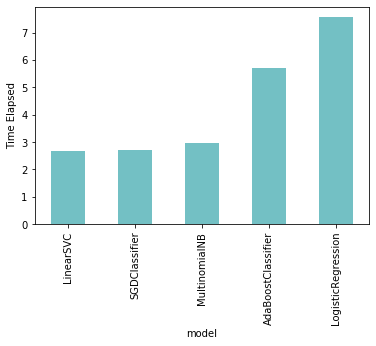

In [664]:
# Time Elasped 
tfidf["time"].sort_values().plot("bar", color=color[4], use_index=True)
plt.ylabel("Time Elapsed")
#plt.xticks([tfidf.model], fontsize=12)
plt.show()

Text(0, 0.5, 'F1-score')

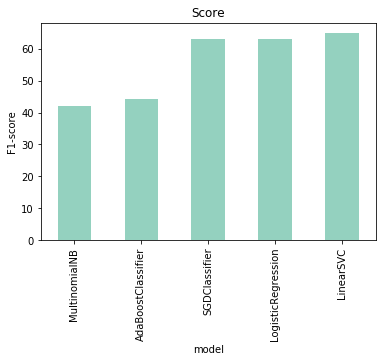

In [662]:
# Score
tfidf.iloc[tfidf['f1'].str[0].argsort()]["f1"].str[0].plot("bar", color=color[5], title="Score", use_index=True)
plt.ylabel("F1-score")

### `Bag of words`

In [659]:
bow = pd.DataFrame(all_mode_information["count"])
bow.set_index("model", inplace=True)

Text(0, 0.5, 'Time Elapsed')

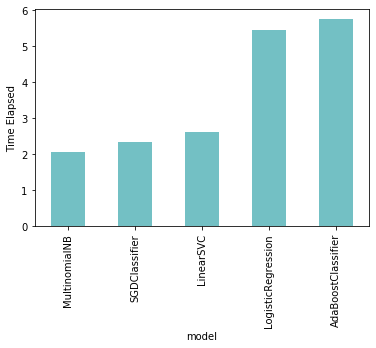

In [660]:
# Time Elasped 
bow["time"].sort_values().plot("bar", color=color[4], use_index=True)
plt.ylabel("Time Elapsed")

Text(0, 0.5, 'F1-score')

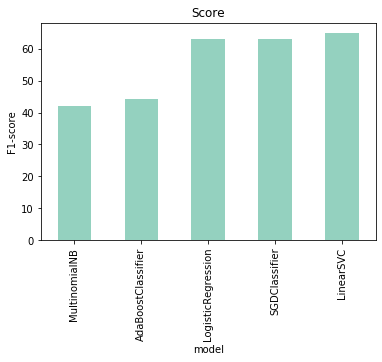

In [663]:
# Scored
bow.iloc[bow['f1'].str[0].argsort()]["f1"].str[0].plot("bar", color=color[5], title="Score", use_index=True)
plt.ylabel("F1-score")

* From the table above - bow feature creation method is performing better than tfidf. 

## `Other tecniques & steps which can be explored:`

#### We can use over-sampling techniques to augment the data and balance the classes probably train again.
* RandomOverSampler
* SMOTE (Synthetic Minority Over-Sampling Technique)

#### Use other method like embedding to create features (pre-trained embeddings)
* Glove
* Word2Vec
* ELMO

####  Optimization of the existing model
* Using grid search cv for parameter tuning
* Creating test set to test the models generalization capability

*************

# `************END************`

************************

### Models

In [593]:
# Other models 

# xgb = XGBClassifier(n_estimators=2000,
#                     tree_method='hist',
#                     subsample=0.67,
#                     colsample_level=0.06,
#                     verbose=0,
#                     n_jobs=6,
#                     random_state=1234)

# lgbm = LGBMClassifier(n_estimators=2000,
#                       feature_fraction=0.06,
#                       bagging_fraction=0.67,
#                       bagging_freq=1,
#                       verbose=0,
#                       n_jobs=6,
#                       random_state=1234)

# cb = CatBoostClassifier(n_estimators=2000,
#                         colsample_bylevel=0.06,
#                         max_leaves=31,
#                         subsample=0.67,
#                         verbose=0,
#                         thread_count=6,
#                         random_state=1234)

# hgbm = HistGradientBoostingClassifier(max_iter=2000,
#                                       validation_fraction=0.1,
#                                       n_iter_no_change=15,
#                                       verbose=0,
#                                       random_state=1234)




In [59]:
# spelling correction

# contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
#                    "can't've": "cannot have", "'cause": "because", "could've": "could have", 
#                    "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
#                    "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
#                    "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
#                    "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
#                    "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
#                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
#                    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
#                    "I'll've": "I will have","I'm": "I am", "I've": "I have", 
#                    "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
#                    "i'll've": "i will have","i'm": "i am", "i've": "i have", 
#                    "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
#                    "it'll": "it will", "it'll've": "it will have","it's": "it is", 
#                    "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
#                    "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
#                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
#                    "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
#                    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
#                    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
#                    "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
#                    "she's": "she is", "should've": "should have", "shouldn't": "should not", 
#                    "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
#                    "this's": "this is",
#                    "that'd": "that would", "that'd've": "that would have","that's": "that is", 
#                    "there'd": "there would", "there'd've": "there would have","there's": "there is", 
#                        "here's": "here is",
#                    "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
#                    "they'll've": "they will have", "they're": "they are", "they've": "they have", 
#                    "to've": "to have", "wasn't": "was not", "we'd": "we would", 
#                    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
#                    "we're": "we are", "we've": "we have", "weren't": "were not", 
#                    "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
#                    "what's": "what is", "what've": "what have", "when's": "when is", 
#                    "when've": "when have", "where'd": "where did", "where's": "where is", 
#                    "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
#                    "who's": "who is", "who've": "who have", "why's": "why is", 
#                    "why've": "why have", "will've": "will have", "won't": "will not", 
#                    "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
#                    "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
#                    "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
#                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
#                    "you'll've": "you will have", "you're": "you are", "you've": "you have" } 
